In [83]:
import yaml
import sys
# reload(sys)
from sklearn.model_selection import train_test_split
import multiprocessing
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary
import gensim
from keras.preprocessing import sequence
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, Activation
from keras.layers.core import Dense, Dropout,Activation
from keras.models import model_from_yaml
np.random.seed(1337)  # For Reproducibility
import jieba
import pandas as pd
import sys
from gensim.corpora import Dictionary
sys.setrecursionlimit(1000000)
# set parameters:
vocab_dim = 100
maxlen = 100
n_iterations = 300  # ideally more..
n_exposures = 10
window_size = 7
batch_size = 32
n_epoch = 4
input_length = 100
cpu_count = multiprocessing.cpu_count()

In [84]:
# load training data
neg = pd.read_csv('../data/neg.csv', header=None,encoding='gb18030')
pos = pd.read_csv('../data/pos.csv', header=None,encoding='gb18030')

combined=np.concatenate((pos[0], neg[0]))
y = np.concatenate((np.ones(len(pos),dtype=int), np.zeros(len(neg),dtype=int)))

In [85]:
def negation_handling(words):
    negations = {'不', '没', '无', '非', '莫', '未', '否'}
    transformed_words = []
    negate = False
    for word in words:
        if word in negations:
            negate = not negate
        else:
            if negate:
                transformed_words.append('NOT_' + word)
            else:
                transformed_words.append(word)
            negate = False
    return transformed_words
def transition_handling(words):
    transitions = {'但是', '然而', '可是', '不过','以前','现在'}
    transformed_words = []
    prefix = ''
    for word in words:
        if word in transitions:
            prefix = 'BUT_'
        else:
            transformed_words.append(prefix + word)
            prefix = ''
    return transformed_words
def tokenizer(text):
    text = [jieba.lcut(document.replace('\n', '')) for document in text]
    text = [negation_handling(sentence) for sentence in text]
    text = [transition_handling(sentence) for sentence in text]
    return text

In [86]:
# train word2vec model
def word2vec_train(combined):
    model = gensim.models.Word2Vec(vector_size=100, min_count=10, window=7, workers=multiprocessing.cpu_count(),epochs=5)
    model.build_vocab(combined)
    model.train(combined, total_examples=model.corpus_count, epochs=model.epochs)
    model.save("lstm_word2vec.model")
    return model

In [87]:
from keras_preprocessing import sequence
from gensim.corpora import Dictionary
def data_transformation(model=None, combined=None):
    if (combined is not None) and (model is not None):
        gensim_dict = Dictionary()
        gensim_dict.add_documents([model.wv.key_to_index], prune_at=None)
        w2indx = {v: k+1 for k, v in gensim_dict.items()} 
        w2vec = {word: model.wv.get_vector(word) for word in w2indx.keys()} 
        data = []
        for sentence in combined:
            new_txt = []
            for word in sentence:
                try:
                    new_txt.append(w2indx[word])
                except:
                    new_txt.append(0)
            data.append(new_txt)
        combined = data
        combined = sequence.pad_sequences(combined, maxlen=maxlen)
    else:
        print('No data provided...')
    n_symbols = len(w2indx) + 1  # 所有单词的索引数，频数小于10的词语索引为0，所以加1
    embedding_weights = np.zeros((n_symbols, vocab_dim))#索引为0的词语，词向量全为0
    for word, index in w2indx.items():#从索引为1的词语开始，对每个词语对应其词向量
        embedding_weights[index, :] = w2vec[word]
    return n_symbols, embedding_weights, w2indx, w2vec, combined

In [88]:
import matplotlib.pyplot as plt
from keras.layers import Bidirectional, Flatten
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.callbacks import EarlyStopping
##定义网络结构
def build_lstm(n_symbols, embedding_weights, x_train, y_train, x_test, y_test):
    print('Defining an Attention-based Keras Model...')
    model = Sequential()
    model.add(Embedding(output_dim=vocab_dim,
                        input_dim=n_symbols,
                        mask_zero=True,
                        weights=[embedding_weights],
                        input_length=input_length))

    # 添加双向 LSTM
    #model.add(Bidirectional(LSTM(units=100, activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(1e-6))))
    model.add(LSTM(units=100, activation='sigmoid',recurrent_activation='hard_sigmoid'))

    # 添加注意力层
    # model.add(SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                            #    kernel_regularizer=regularizers.l2(1e-6),
                            #    bias_regularizer=regularizers.l1(1e-4),
                            #    attention_regularizer_weight=1e-4,
                            #    name='Attention'))
    
    model.add(Dropout(0.5))
    # 添加全连接层
    # model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print('Compiling the Model...')
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

    print("Train...")
    #early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_data=(x_test, y_test))

    
    print("Evaluate...")
    score = model.evaluate(x_test, y_test, batch_size=batch_size)

    # 绘制训练和验证的损失值和准确率
    plot_history(history)

    model.save('attention_lstm.h5')
    print('Test score:', score)

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

Defining an Attention-based Keras Model...
Compiling the Model...
Train...
Epoch 1/4
528/528 [==============================] - 36s 66ms/step - loss: 0.5586 - accuracy: 0.7057 - val_loss: 0.3637 - val_accuracy: 0.8591
Epoch 2/4
528/528 [==============================] - 35s 65ms/step - loss: 0.3114 - accuracy: 0.8797 - val_loss: 0.2494 - val_accuracy: 0.9051
Epoch 3/4
528/528 [==============================] - 35s 66ms/step - loss: 0.2063 - accuracy: 0.9286 - val_loss: 0.2200 - val_accuracy: 0.9160
Epoch 4/4
528/528 [==============================] - 35s 66ms/step - loss: 0.1499 - accuracy: 0.9502 - val_loss: 0.2158 - val_accuracy: 0.9219
Evaluate...
132/132 [==============================] - 2s 13ms/step - loss: 0.2158 - accuracy: 0.9219


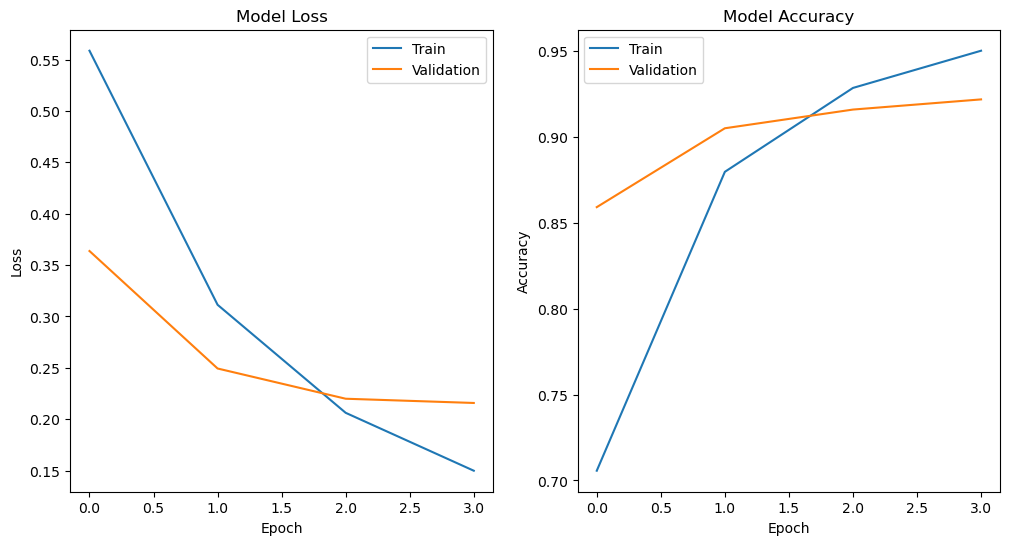

Test score: [0.21584074199199677, 0.921875]


In [89]:
x_train, x_test, y_train, y_test = train_test_split(data_transformation(word2vec_train(tokenizer(combined)),tokenizer(combined))[4], y, test_size=0.2, random_state=42)
n_symbols,embedding_weights = data_transformation(word2vec_train(tokenizer(combined)),tokenizer(combined))[0:2]
build_lstm(n_symbols,embedding_weights,x_train,y_train,x_test,y_test)

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model = load_model('attention_lstm.h5')
y_pred = model.predict(x_test)
y_pred_binary = np.round(y_pred).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

132/132 [==============================] - 2s 13ms/step
Accuracy: 0.9219
Precision: 0.9130
Recall: 0.9366
F1 Score: 0.9247


In [90]:
def input_transform(string):
    words=jieba.lcut(string)
    words=np.array(words).reshape(1,-1)
    model=gensim.models.Word2Vec.load("lstm_word2vec.model")
    combined = data_transformation(model,words)[4]
    return combined

In [91]:
from keras.models import load_model
def lstm_predict(string):
    print('loading model......')
    model = load_model('lstm.h5')
    print('loading weights......')
    model.load_weights('lstm.h5')
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',metrics=['accuracy'])
    data = input_transform(string)
    data.reshape(1,-1)
    result = model.predict(data)
    threshold = 0.5
    predicted_labels = np.zeros_like(result)
    predicted_labels[result >= threshold] = 1
    return predicted_labels

In [92]:
string = '我不知道你们为什么要喷八戒？八戒的项目不够好吗？收的钱还不够少吗？客服态度不够好吗？我的项目在八戒上就运行的不错，才被坑10来万而已！'
lstm_predict(string)

loading model......
loading weights......
1/1 [==============================] - 0s 93ms/step


array([[0.]], dtype=float32)

In [93]:
zbj = pd.read_csv('../data/zbj_new.csv',encoding='utf-8')
zbj

,内容
0,八戒，陪你玩了7年了，感觉你现在眼里除了钱就是钱，我们像是被你锁在笼子里开膛破肚取胆汁的月熊...
1,哎 现在想进入其实不是好时候了
2,打算进去做推广 看见现在这版面 直接退出了
3,猪八戒已经不是以前的猪八戒，唯利是图
4,是的..猪八戒现在就是个LJ...我也离开了...以前还是挺感激猪八戒的..也赚到了第一桶金...
...,...
1197,然后细心看了一下那个雇主的任务，所有交稿的人都不合格！！虽然没去看其他人的稿子有没有用过，但...
1198,我又看了看这个人的资料，他提出的需求中，别人交稿的基本上没几个是合格的。所以说，这个人骗人已...
1199,所以，建议大家在猪八戒做任务的时候注意一些无良雇主。第一，不要看着价格高点儿就做，有些时候很...
1200,自言自语了这么多，说出来就舒坦些了。但愿对大家有些帮助，谨防骗子！！！


In [103]:
zbj_dic = {}
i = zbj.values[0]
zbj_dic[i[0]] = lstm_predict(i[0])[0]
zbj_dic
for i in zbj.values:
   zbj_dic[i[0]] = lstm_predict(i[0])[0]
zbj_dic

loading model......
loading weights......
1/1 [==============================] - 0s 119ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 103ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 108ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 106ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 137ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 312ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 110ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 113ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 111ms/step
loading model......
loading weights......
1/1 [==============================] - 0s 106ms/step
loading model......
loading weights......
1/1 [===

{'八戒，陪你玩了7年了，感觉你现在眼里除了钱就是钱，我们像是被你锁在笼子里开膛破肚取胆汁的月熊，你总是喂不饱，但我们却越来越痛苦，一路走来，你每改一次版就走一批服务商，现在身边的那些老牌的，有实力的基本都看不到了，全部都是新面孔，今年的规则你们做的这么绝，我打算也不陪你玩了，玩不起，也好累，当然，你并不会在乎，各自安好吧。我并不想骂你，毕竟你以前是那么优秀并且给了我们小服务商那么多机会。足矣！': array([0.], dtype=float32),
 '哎 现在想进入其实不是好时候了': array([0.], dtype=float32),
 '打算进去做推广 看见现在这版面 直接退出了': array([0.], dtype=float32),
 '猪八戒已经不是以前的猪八戒，唯利是图': array([0.], dtype=float32),
 '是的..猪八戒现在就是个LJ...我也离开了...以前还是挺感激猪八戒的..也赚到了第一桶金...现在粉转黑了..': array([0.], dtype=float32),
 '我干八戒四年了，现在看到八戒也很恶心，就是希望十天后一万的保证金能退出来！以后别恶心我们服务商了！': array([0.], dtype=float32),
 '唉，中介费这么高，感觉现在就是一个坑啊': array([0.], dtype=float32),
 '已退坑！！': array([0.], dtype=float32),
 '抓八戒是怎么活下来的，全是要钱要钱要钱，我是真的服了，刚才打开猪八戒一看，全是钱钱钱钱。要脸不要！': array([0.], dtype=float32),
 '刚开始的时候，后来越来越不把设计师当人看，早就退坑了': array([0.], dtype=float32),
 '曝光猪八戒网上的一个服务商，河南千真信息科技有限公司和河南扬名网络科技有限公司是同一个公司，9天工期，半年没给我交付，强行不退款，强行拿其他软件顶我的项目金。猪八戒官方一再包庇，说我证据不足？我天，那签合同都不顶用的吗？9天工期，半年没交付我，还***证据不足，猪八戒吃相太难看了。《重庆晚报》出身的董事长果然不同常人啊。': array([0.], dtype=float32),
 '弱弱的问一句，怎么举报猪八戒这个平台

In [104]:
final = pd.DataFrame(zbj_dic.items(),columns=['content','label'])
final['label'] = final['label'].astype(int)
final

,content,label
0,八戒，陪你玩了7年了，感觉你现在眼里除了钱就是钱，我们像是被你锁在笼子里开膛破肚取胆汁的月熊...,0
1,哎 现在想进入其实不是好时候了,0
2,打算进去做推广 看见现在这版面 直接退出了,0
3,猪八戒已经不是以前的猪八戒，唯利是图,0
4,是的..猪八戒现在就是个LJ...我也离开了...以前还是挺感激猪八戒的..也赚到了第一桶金...,0
...,...,...
1173,然后细心看了一下那个雇主的任务，所有交稿的人都不合格！！虽然没去看其他人的稿子有没有用过，但...,0
1174,我又看了看这个人的资料，他提出的需求中，别人交稿的基本上没几个是合格的。所以说，这个人骗人已...,0
1175,所以，建议大家在猪八戒做任务的时候注意一些无良雇主。第一，不要看着价格高点儿就做，有些时候很...,0
1176,自言自语了这么多，说出来就舒坦些了。但愿对大家有些帮助，谨防骗子！！！,0


In [105]:
final.to_csv('../data/zbj_lstm_result.csv',index=False,encoding='gb18030')